Based on:
https://github.com/ml4a/ml4a-guides/blob/master/notebooks/recurrent_neural_networks.ipynb

## Recurrent Neural Networks: Character RNNs with Keras

Often we are not interested in isolated datapoints, but rather datapoints within a context of others. A datapoint may mean something different depending on what's come before it. This can typically be represented as some kind of _sequence_ of datapoints, perhaps the most common of which is a time series.

One of the most ubiquitous sequences of data where context is especially important is natural language. We have quite a few words in English where the meaning of a word may be totally different depending on it's context. An innocuous example of this is "bank": "I went fishing down by the river bank" vs "I deposited some money into the bank".

If we consider that each word is a datapoint, most non-recurrent methods will treat "bank" in the first sentence exactly the same as "bank" in the second sentence - they are indistinguishable. If you think about it, in isolation they are indistinguishable to us as well - it's the same word!

We can only start to discern them when we consider the previous word (or words). So we might want our neural network to consider that "bank" in the first sentence is preceded by "river" and that in the second sentence "money" comes a few words before it. That's basically what RNNs do - they "remember" some of the previous context and that influences the output it produces. This "memory" (called the network's "_hidden state_") works by retaining some of the previous outputs and combining it with the current input; this recursing (feedback) of the network's output back into itself is where its name comes from.

This recursing makes RNNs quite deep, and thus they can be difficult to train. The gradient gets smaller and smaller the deeper it is pushed backwards through the network until it "vanishes" (effectively becomes zero), so long-term dependencies are hard to learn. The typical practice is to only extend the RNN back a certain number of time steps so the network is still trainable.

Certain units, such as the LSTM (long short-term memory) and GRU (gated recurrent unit), have been developed to mitigate some of this vanishing gradient effect.

Let's walkthrough an example of a character RNN, which is a great approach for learning a character-level language model. A language model is essentially some function which returns a probability over possible words (or in this case, characters), based on what has been seen so far. This function can vary from region to region (e.g. if terms like "pop" are used more commonly than "soda") or from person to person. You could say that a (good) language model captures the style in which someone writes.

Language models often must make the simplifying assumption that only what came immediately (one time step) before matters (this is called the "Markov assumption"), but with RNNs we do not need to make such an assumption.

We'll use Keras which makes building neural networks extremely easy (this example is an annotated version of Keras's [LSTM text generation example](https://github.com/fchollet/keras/blob/master/examples/lstm_text_generation.py)).

First we'll do some simple preparation - import the classes we need and load up the text we want to learn from.

In [1]:
import os

#if using Theano with GPU
#os.environ["THEANO_FLAGS"] = "mode=FAST_RUN,device=gpu,floatX=float32"

import random
import numpy as np
from glob import glob
from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers.core import Dense, Activation, Dropout

Using TensorFlow backend.


In [2]:
%matplotlib inline
from matplotlib import pyplot as plt

In [3]:
# load up our text
text_files = glob('../data/sotu/*.txt')
text_files[0:5]

['../data/sotu/Barack-Obama_2009.txt',
 '../data/sotu/George-W.-Bush_2006.txt',
 '../data/sotu/Dwight-D.-Eisenhower_1959.txt',
 '../data/sotu/Barack-Obama_2013.txt',
 '../data/sotu/Ronald-Reagan_1983.txt']

In [4]:
# let us create a long string variable text
text = '\n'.join([open(f, 'r').read() for f in text_files])
text[0:500]

"Madam Speaker, Mr. Vice President, Members of Congress, the First Lady of the United States--she's around here somewhere: I have come here tonight not only to address the distinguished men and women in this great Chamber, but to speak frankly and directly to the men and women who sent us here. \nI know that for many Americans watching right now, the state of our economy is a concern that rises above all others, and rightly so. If you haven't been personally affected by this recession, you probabl"

In [5]:
print(type(text))
print(len(text))

<type 'str'>
2942837


In [6]:
# extract all (unique) characters
# these are our "categories" or "labels". We want to predict the next character from the past few (e.g 20) characters
chars = list(set(text))
print(chars)


[' ', '$', '(', ',', '0', '4', '8', 'D', 'H', 'L', 'P', 'T', 'X', '`', 'd', 'h', 'l', 'p', 't', 'x', "'", '+', '/', '3', '7', ';', '\xbc', '?', 'C', 'G', 'K', 'O', 'S', 'W', '[', '_', 'c', 'g', 'k', 'o', 's', 'w', '\n', '\x95', '"', '&', '*', '.', '2', '6', ':', '\xbd', 'B', 'F', 'J', 'N', 'R', 'V', 'Z', 'b', 'f', 'j', 'n', 'r', 'v', 'z', '!', '\xa2', '%', ')', '-', '1', '5', '9', 'A', '\xc2', 'E', 'I', 'M', 'Q', 'U', 'Y', ']', 'a', 'e', 'i', 'm', 'q', 'u', 'y']


In [7]:
len(chars)

90

In [8]:
# set a fixed vector size
# so we look at specific windows of characters
max_len = 20

Now we'll define our RNN. Keras makes this trivial:

In [9]:
model = Sequential()
model.add(LSTM(512, return_sequences=True, input_shape=(max_len, len(chars))))
model.add(Dropout(0.2))
model.add(LSTM(512, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(len(chars)))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop')

In [10]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 20, 512)           1234944   
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 512)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 512)               2099200   
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 90)                46170     
_________________________________________________________________
activation_1 (Activation)    (None, 90)                0         
Total params: 3,380,314
Trainable params: 3,380,314
Non-trainable params: 0
_________________________________________________________________


We're framing our task as a classification task. Given a sequence of characters, we want to predict the next character. We equate each character with some label or category (e.g. "a" is 0, "b" is 1, etc).

We use the _softmax_ activation function on our output layer - this function is used for categorical output. It turns the output into a probability distribution over the categories (i.e. it makes the values the network outputs sum to 1). So the network will essentially tell us how strongly it feels about each character being the next one.

The categorical cross-entropy loss the standard loss function for multilabel classification, which basically penalizes the network more the further off it is from the correct label.

We use dropout here to prevent overfitting - we don't want the network to just return things already in the text, we want it to have some wiggle room and create novelty! Dropout is a technique where, in training, some percent (here, 20%) of random neurons of the associated layer are "turned off" for that epoch. This prevents overfitting by preventing the network from relying on particular neurons.

That's it for the network architecture!

To train, we have to do some additional preparation. We need to chop up the text into character sequences of the length we specified (`max_len`) - these are our training inputs. We match them with the character that immediately follows each sequence. These are our expected training outputs.

For example, say we have the following text (this quote is from Zhuang Zi). With `max_len=20`, we could manually create the first couple training examples like so:

In [11]:
example_text = "The fish trap exists because of the fish. Once you have gotten the fish you can forget the trap. The rabbit snare exists because of the rabbit. Once you have gotten the rabbit, you can forget the snare. Words exist because of meaning. Once you have gotten the meaning, you can forget the words. Where can I find a man who has forgotten words so that I may have a word with him?"

# step size here is 3, but we can vary that
input_1 = example_text[0:20]
true_output_1 = example_text[20]
# >>> 'The fish trap exists'
# >>> ' '
print(input_1)
print(true_output_1)


The fish trap exists
 


In [12]:
input_2 = example_text[3:23]
true_output_2 = example_text[23]
# >>> 'fish trap exists be'
# >>> 'c'
print(input_2)
print(true_output_2)


 fish trap exists be
c


In [13]:
input_3 = example_text[6:26]
true_output_3 = example_text[26]
# >>> 'sh trap exists becau'
# >>> 's'

# etc
print(input_3)
print(true_output_3)


sh trap exists becau
s


We can generalize this like so:

In [14]:
step = 3
inputs = []
outputs = []
for i in range(0, len(text) - max_len, step):
    inputs.append(text[i:i+max_len])
    outputs.append(text[i+max_len])

In [15]:
print(len(inputs),len(outputs))


(980939, 980939)


In [16]:
# Let us see a specific example for the input text and the output
print(inputs[1995], outputs[1995])

("ington, we've all se", 'e')


We also need to map each character to a label and create a reverse mapping to use later:

In [17]:
char_labels = {ch:i for i, ch in enumerate(chars)}
labels_char = {i:ch for i, ch in enumerate(chars)}

In [18]:
print(char_labels)

{' ': 0, '$': 1, '(': 2, ',': 3, '0': 4, '4': 5, '8': 6, 'D': 7, 'H': 8, 'L': 9, 'P': 10, 'T': 11, 'X': 12, '`': 13, 'd': 14, 'h': 15, 'l': 16, 'p': 17, 't': 18, 'x': 19, "'": 20, '+': 21, '/': 22, '3': 23, '7': 24, ';': 25, '\xbc': 26, '?': 27, 'C': 28, 'G': 29, 'K': 30, 'O': 31, 'S': 32, 'W': 33, '[': 34, '_': 35, 'c': 36, 'g': 37, 'k': 38, 'o': 39, 's': 40, 'w': 41, '\n': 42, '\x95': 43, '"': 44, '&': 45, '*': 46, '.': 47, '2': 48, '6': 49, ':': 50, '\xbd': 51, 'B': 52, 'F': 53, 'J': 54, 'N': 55, 'R': 56, 'V': 57, 'Z': 58, 'b': 59, 'f': 60, 'j': 61, 'n': 62, 'r': 63, 'v': 64, 'z': 65, '!': 66, '\xa2': 67, '%': 68, ')': 69, '-': 70, '1': 71, '5': 72, '9': 73, 'A': 74, '\xc2': 75, 'E': 76, 'I': 77, 'M': 78, 'Q': 79, 'U': 80, 'Y': 81, ']': 82, 'a': 83, 'e': 84, 'i': 85, 'm': 86, 'q': 87, 'u': 88, 'y': 89}


In [19]:
print(labels_char)

{0: ' ', 1: '$', 2: '(', 3: ',', 4: '0', 5: '4', 6: '8', 7: 'D', 8: 'H', 9: 'L', 10: 'P', 11: 'T', 12: 'X', 13: '`', 14: 'd', 15: 'h', 16: 'l', 17: 'p', 18: 't', 19: 'x', 20: "'", 21: '+', 22: '/', 23: '3', 24: '7', 25: ';', 26: '\xbc', 27: '?', 28: 'C', 29: 'G', 30: 'K', 31: 'O', 32: 'S', 33: 'W', 34: '[', 35: '_', 36: 'c', 37: 'g', 38: 'k', 39: 'o', 40: 's', 41: 'w', 42: '\n', 43: '\x95', 44: '"', 45: '&', 46: '*', 47: '.', 48: '2', 49: '6', 50: ':', 51: '\xbd', 52: 'B', 53: 'F', 54: 'J', 55: 'N', 56: 'R', 57: 'V', 58: 'Z', 59: 'b', 60: 'f', 61: 'j', 62: 'n', 63: 'r', 64: 'v', 65: 'z', 66: '!', 67: '\xa2', 68: '%', 69: ')', 70: '-', 71: '1', 72: '5', 73: '9', 74: 'A', 75: '\xc2', 76: 'E', 77: 'I', 78: 'M', 79: 'Q', 80: 'U', 81: 'Y', 82: ']', 83: 'a', 84: 'e', 85: 'i', 86: 'm', 87: 'q', 88: 'u', 89: 'y'}


Now we can start constructing our numerical input 3-tensor and output matrix. Each input example (i.e. a sequence of characters) is turned into a matrix of one-hot vectors; that is, a bunch of vectors where the index corresponding to the character is set to 1 and all the rest are set to zero.

For example, if we have the following:

In [20]:
# assuming max_len = 7
# so our examples have 7 characters, e.g these ones:
example = 'cab dab'
# these are the character 'codes':
example_char_labels = {
    'a': 0,
    'b': 1,
    'c': 2,
    'd': 3,
    ' ' : 4
}

# matrix form
# the example uses only five kinds of characters,
# so the vectors only need to have five components,
# and since the input phrase has seven characters,
# the matrix has seven vectors.
[
    [0, 0, 1, 0, 0], # c
    [1, 0, 0, 0, 0], # a
    [0, 1, 0, 0, 0], # b
    [0, 0, 0, 0, 1], # (space)
    [0, 0, 0, 1, 0], # d
    [1, 0, 0, 0, 0], # a
    [0, 1, 0, 0, 0]  # b
]

[[0, 0, 1, 0, 0],
 [1, 0, 0, 0, 0],
 [0, 1, 0, 0, 0],
 [0, 0, 0, 0, 1],
 [0, 0, 0, 1, 0],
 [1, 0, 0, 0, 0],
 [0, 1, 0, 0, 0]]

That matrix represents a _single_ training example, so for our full set of training examples, we'd have a stack of those matrices (hence a 3-tensor).

![A 3-tensor of training examples](../assets/rnn_3tensor.png)

And the outputs for each example are each a one-hot vector (i.e. a single character). With that in mind:

In [21]:
# using bool to reduce memory usage
X = np.zeros((len(inputs), max_len, len(chars)), dtype=np.bool)
y = np.zeros((len(inputs), len(chars)), dtype=np.bool)

print(X.shape)
print(y.shape)

(980939, 20, 90)
(980939, 90)


In [22]:
# set the appropriate indices to 1 in each one-hot vector
for i, example in enumerate(inputs):
    for t, char in enumerate(example):
        X[i, t, char_labels[char]] = 1
    y[i, char_labels[outputs[i]]] = 1

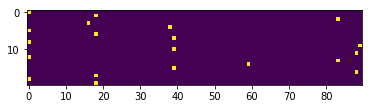

In [23]:
#Let us plot a specific sentence
plt.imshow(X[1345,:,:])

In [24]:
# Let us look at an example input
print(X[13,15,:])


[False False False  True False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False]


In [25]:
# Let us look at an example label
print(y[230,:])

[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False  True False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False]


Now that we have our training data, we can start training. Keras also makes this easy:

In [26]:
# more epochs is usually better, but training can be very slow if not on a GPU
#epochs = 10
#model.fit(X, y, batch_size=128, epochs=epochs)

It's much more fun to see your network's ramblings as it's training, so let's write a function to produce text from the network:

In [27]:
# Let us see how to sample from a Boltzmann distribution with parameters probs and temperature
probs=[3,1,1,4]
temperature=2.3

a = np.log(probs)/temperature
dist = np.exp(a)/np.sum(np.exp(a))
choices = range(len(probs))
print(dist)
print(choices)
print(np.random.choice(choices, p=dist))

[ 0.29640983  0.18384362  0.18384362  0.33590293]
[0, 1, 2, 3]
2


In [28]:
# A function to draw samples from a Boltzmann distribution
def sample(probs, temperature):
    """samples an index from a vector of probabilities
    (this is not the most efficient way but is more robust)"""
    a = np.log(probs)/temperature
    dist = np.exp(a)/np.sum(np.exp(a))
    choices = range(len(probs))
    return np.random.choice(choices, p=dist)

In [29]:
temperature=0.35 
seed=None 
num_chars=100

#Let us define a lambda function that checks if a given sentence is a long enough
predict_more=lambda x: len(x) < num_chars
predict_more('This sentence is too short')

True

In [30]:
print(max_len)
# Let us select a random seed sentences
start_idx = random.randint(0, len(text) - max_len - 1)
seed = text[start_idx:start_idx + max_len]

sentence = seed
print(sentence)

20
nditure. If we shall


In [31]:
# generate the input tensor
# from the last max_len characters generated so far
x = np.zeros((1, max_len, len(chars)))
for t, char in enumerate(sentence):
    x[0, t, char_labels[char]] = 1.
print(x.shape)

(1, 20, 90)


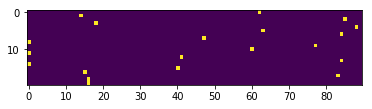

In [32]:
plt.imshow(x[0,:,:])

In [33]:
probs = model.predict(x, verbose=1)[0]

1/1 [==============================] - 1s 738ms/step


In [34]:
print(probs)
print(probs.shape)

[ 0.01130546  0.01110293  0.01102405  0.01116512  0.01113562  0.01098717
  0.01115525  0.01096082  0.01101032  0.01106882  0.01113106  0.01121505
  0.01117632  0.01113371  0.01119748  0.01123222  0.01107901  0.01109849
  0.01119627  0.0111445   0.01103457  0.01104022  0.01092154  0.01112431
  0.01117794  0.01103014  0.01116547  0.01123506  0.01118313  0.01114872
  0.01122881  0.01125753  0.0111533   0.01110242  0.01112818  0.01106695
  0.01089225  0.01102814  0.01100018  0.01108737  0.01101981  0.01123687
  0.01125035  0.01118481  0.01100309  0.011121    0.0109372   0.01101578
  0.01107662  0.01116084  0.01133373  0.01115015  0.01115837  0.01113118
  0.01099731  0.01118204  0.01113029  0.01111502  0.01113723  0.01105817
  0.01106812  0.01110353  0.011106    0.01103971  0.01113547  0.01123028
  0.01111692  0.01118257  0.01104378  0.01115162  0.01118764  0.01115912
  0.01110849  0.01116431  0.0111554   0.01091264  0.01109991  0.01109689
  0.01099797  0.01100485  0.01110299  0.01114752  0

In [35]:
# Based on these ideas, let us create a generate function
def generate(temperature=0.35, seed=None, num_chars=100):
    predict_more=lambda x: len(x) < num_chars
    
    if seed is not None and len(seed) < max_len:
        raise Exception('Seed text must be at least {} chars long'.format(max_len))

    # if no seed text is specified, randomly select a chunk of text
    else:
        start_idx = random.randint(0, len(text) - max_len - 1)
        seed = text[start_idx:start_idx + max_len]

    sentence = seed
    generated = sentence

    while predict_more(generated):
        # generate the input tensor
        # from the last max_len characters generated so far
        x = np.zeros((1, max_len, len(chars)))
        for t, char in enumerate(sentence):
            x[0, t, char_labels[char]] = 1.

        # this produces a probability distribution over characters
        probs = model.predict(x, verbose=0)[0]

        # sample the character to use based on the predicted probabilities
        next_idx = sample(probs, temperature)
        next_char = labels_char[next_idx]

        generated += next_char
        sentence = sentence[1:] + next_char
    return generated

The _temperature_ controls how random we want the network to be. Lower temperatures favors more likely values, whereas higher temperatures introduce more and more randomness. At a high enough temperature, values will be chosen at random.

With this generation function we can modify how we train the network so that we see some output at each step:

In [36]:
# serialize model to JSON
model_json = model.to_json()
with open("text_gen_model.json", "w") as json_file:
    json_file.write(model_json)


In [ ]:
# Let us train for 10 epochs
epochs = 10
for i in range(epochs):
    print('epoch %d'%i)

    # set nb_epoch to 1 since we're iterating manually
    # comment this out if you just want to generate text
    model.fit(X, y, batch_size=128, epochs=1)

    # preview
    for temp in [0.2, 0.5, 1., 1.2]:
        print('temperature: %0.2f'%temp)
        print('%s'%generate(temperature=temp))
    
    # serialize weights to HDF5
    fname="text_gen_model_params_"+str(i)+".h5"
    # save the model weights
    model.save_weights(fname)
    print("Saved model to disk")


epoch 0
Epoch 1/1
119936/980939 [==>...........................] - ETA: 12:04 - loss: 2.4250

That's about all there is to it. Let's try to generate one long sample passage with 2000 characters. We'll arbitrarily pick a temperature of 0.4, which seems to work decently well -- enough randomness without being incoherent. We'll also give it a seed this time (starting text): "Today, we are facing an important challenge"

In [ ]:
# Let us generate some text
print('%s' % generate(temperature=0.4, seed='Today, we are facing an important challenge.', num_chars=2000))

In [ ]:
# Let us load a saved model from disk
from keras.models import model_from_json
# load json and create model
json_file = open('text_gen_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
                 
model = model_from_json(loaded_model_json)
# load weights into new model
fname="text_gen_model_params_9.h5"
model.load_weights(fname)
print("Loaded model from disk")

In [ ]:
# generate text from the current model
print('%s' % generate(temperature=0.4, seed='Today, we are facing an important challenge.', num_chars=2000))
